<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/GaussianMRFExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Markov Random Fields

A Markov random field or MRF is an *undirected* graphical model where the energy is given by the som of unary and multi-variable potentials $\psi$:

$$
E(X) = \sum_j \psi_j(x_j) + \sum_c \psi_c(X_c)
$$

where $j$ ranges over the variable nodes $x_j$ and $c$ indexes over cliques in the graph of variables. We use $X_c$ to denote all variables associated with clique $c$. A typical case is a pairwise Gaussian MRF, where

- the $\psi_j(x_j)$ are quadratic potentials $\|A_j x_j-b_j\|^2_{R_j}$ associated with measurements $b_j$.
- the $\psi_c(X_c)=\psi_c(x_{j_1},x_{j_2})$ are pairwise potentials $\|A_{j_1} x_{j_1}+A_{j_2} x_{j_2}-b_c\|^2_{Q_c}$ over pairwise cliques $X_c=\{x_{j_1},x_{j_2}\}$, typically enforcing smoothness.

It will not surprise anyone, that Gaussian MRF's can easily and advantageously be represented using Gaussian factor graphs. Indeed, we can rewrite the energy $E(X)$ as

$$
E(X) = \sum_i \phi_i(X_i)
$$

where the factors $\phi_i(X_i)$ encompass both unary and binary factors, and of course we can add arbitrary arity factors as well.

Below we create a small "image "example, and show how we can solve it the same tools as the ones we used in the Kalman smoothing examples.

In [1]:
%pip -q install gtbook  # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

import gtsam
from gtbook.display import show
from gtbook.gaussian import sample_bayes_net
from gtsam import noiseModel

## A Small "Image" MRF


We first define the image dimensions and set up some keys referring to rows by a letter and columns by an integer:

In [3]:
M, N = 3, 4  # try playing with this
row_symbols = [chr(ord('a')+row) for row in range(M)]
keys = {(row, col): gtsam.symbol(row_symbols[row], col+1)
       for row in range(M) for col in range(N)}

We create random data, and define a noise model for the data with the right  standard deviation:

In [4]:
sigma = 0.5
rng = np.random.default_rng(42)
data = rng.normal(loc=0, scale=sigma, size=(M, N, 1))
data_model = noiseModel.Isotropic.Sigmas([sigma])
print("data:\n", np.round(data[:,:,0],2))
print(f"{data_model=}")

data:
 [[ 0.15 -0.52  0.38  0.47]
 [-0.98 -0.65  0.06 -0.16]
 [-0.01 -0.43  0.44  0.39]]
data_model=isotropic dim=1 sigma=0.5



For smoothness, we use a different noise model:

In [5]:
smoothness_sigma = 0.5
smoothness_model = noiseModel.Isotropic.Sigmas([smoothness_sigma])
print(f"{smoothness_model=}")

smoothness_model=isotropic dim=1 sigma=0.5



Then we create the factor graph:

In [6]:
I = np.eye(1, 1, dtype=float)
zero = np.zeros((1,1))
graph = gtsam.GaussianFactorGraph()
for row in range(M):
    for col in range(N):
        # add data terms:
        j = keys[(row,col)]
        graph.add(j, I, np.array(data[row,col]), data_model)
        # add smoothness terms:
        if col>0:
            j1 = keys[(row,col-1)]
            graph.add(j, I, j1, -I, zero, smoothness_model)
        if row>0:
            j2 = keys[(row-1,col)]
            graph.add(j, I, j2, -I, zero, smoothness_model)

We can display the graph, although graphviz (our graph plotting engine) does not respect the "image" nature. Note that we omit the "dot" for binary factors, which both reveals the undirected MRF and is easier on the eye.

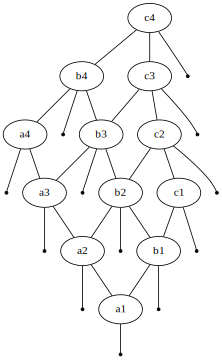

In [7]:
position_hints = {c:float(-i) for i,c in enumerate(row_symbols)}
show(graph, binary_edges=True) # you can add hints=position_hints for a different view

## Inference using a Direct Solver

As in Kalman smoothing, we can use multi-frontal elimination, using a "nested dissection" ordering:

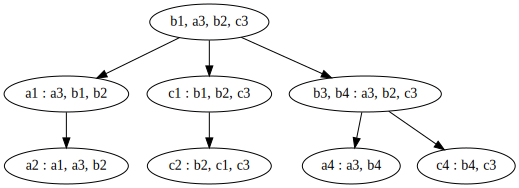

In [8]:
nested = gtsam.Ordering.MetisGaussianFactorGraph(graph)
nested_bayes_tree = graph.eliminateMultifrontal(nested)
show(nested_bayes_tree)

In this case, the structure of the Bayes tree reveals that (for M=3,N=4) the image is split into three regions that are separately solved.

Unfortunately, the wrapper does not support easy visualization of the "divide and conquer" approach of nested dissection, but here is an ascii image showing the first "cut", dividing up the image into regions handled by the left, middle, and right branches, respectively:

```
  1 2 3 4
  _______
a|l l * r|
b|* * r r|
c|m m * r|
```

The MAP solution is obtained by back-substitution, and can be seen as a smoother version of the data:

In [9]:
mean = nested_bayes_tree.optimize()
print("data:\n", np.round(data[:,:,0],2))
print("mean:")
for row in range(M):
    print([np.round(mean.at(keys[(row,col)]).item(),2) for col in range(N)])

data:
 [[ 0.15 -0.52  0.38  0.47]
 [-0.98 -0.65  0.06 -0.16]
 [-0.01 -0.43  0.44  0.39]]
mean:
[-0.16, -0.22, 0.09, 0.21]
[-0.41, -0.3, 0.0, 0.06]
[-0.21, -0.21, 0.11, 0.18]


And of course, now ancestral sampling can also be done in parallel (here in the Bayes net):

In [10]:
gbn = graph.eliminateSequential(nested)
samples = sample_bayes_net(gbn, 3)
for row in range(M):
    print(" ".join([str(np.round(samples[keys[(row,col)]],2)) for col in range(N)]))

[[-0.49 -0.02  0.13]] [[-0.1   0.21 -0.83]] [[ 0.49  0.04 -0.05]] [[ 0.43 -0.13 -0.16]]
[[-0.37 -0.24 -0.86]] [[ 0.04 -0.39 -0.43]] [[0.25 0.08 0.42]] [[-0.06  0.31 -0.27]]
[[-0.35  0.3  -0.5 ]] [[-0.22 -0.22 -0.45]] [[0.08 0.19 0.47]] [[ 0.09  0.66 -0.13]]


## Discussion

Direct (multi-frontal) elimination), as shown above, works like a charm in Gaussian Markov random fields with arbitrary connectivity. However, this will *only* scale up to large graphs when small "separators" are to be found. In particular, in image applications, the smallest separator that can be found will always be the smallest image dimension, here $n=\min(M,N)$, and hence the root clique of the Bayes tree will have that dimension as well. When images are large, this will be prohibitively expensive, as a dense $n \times n$ matrix will have to be factorized, and we might need to resort to different methods. Still, $256\times256$ images for example are well within reach for exact inference. 

In the next section we discuss loopy belief propagation and Gibbs sampling as alternatives.